In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
df=pd.read_excel("online_retail_II.xlsx", sheet_name= 'Year 2010-2011')

In [3]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [6]:
df['Customer ID'].unique

<bound method Series.unique of 0         17850.0
1         17850.0
2         17850.0
3         17850.0
4         17850.0
           ...   
541905    12680.0
541906    12680.0
541907    12680.0
541908    12680.0
541909    12680.0
Name: Customer ID, Length: 541910, dtype: float64>

In [7]:
# As Description is not much usefull for customer lifetime values prediction so we can drop this column
df = df.drop(columns=['Description'])

In [8]:
df.isnull().sum()

Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [9]:
#  As we have 5 lakh+ rows in our data so dropping 1 lakh rows having null Customer id will not affect pur model accuracy. 
# As 80% of our data has valid customers
df = df[df['Customer ID'].notnull()]

In [10]:
df.shape

(406830, 7)

In [11]:
df.isnull().sum()

Invoice        0
StockCode      0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [12]:
# Remove canceled transactions (InvoiceNo starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [13]:
df.shape

(397925, 7)

In [14]:
# Remove rows with non-positive quantities
df = df[df['Quantity'] > 0]

In [15]:
# Remove rows with non-positive unit prices
df = df[df['Price'] > 0]

In [16]:
df.shape

(397885, 7)

In [17]:
df['Total Price']=df['Quantity']*df['Price']

In [18]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [19]:
df['Invoice Day']=df['InvoiceDate'].dt.date

In [20]:
df['Hour']=df['InvoiceDate'].dt.hour

In [21]:
df

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price,Invoice Day,Hour
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,8
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,8
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,8
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,8
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,8
...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09,12
541906,581587,23254,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09,12
541907,581587,23255,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09,12
541908,581587,22138,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011-12-09,12


## EDA

In [22]:
top_countries = df.groupby('Country')['Total Price'].sum().sort_values(ascending=False).head(10)

In [23]:
print(top_countries)

Country
United Kingdom    7308391.554
Netherlands        285446.340
EIRE               265545.900
Germany            228867.140
France             209042.050
Australia          138521.310
Spain               61577.110
Switzerland         56443.950
Belgium             41196.340
Sweden              38378.330
Name: Total Price, dtype: float64


C:\Users\Saksham Kaushik\AppData\Local\Temp\ipykernel_8620\142158016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="plasma")


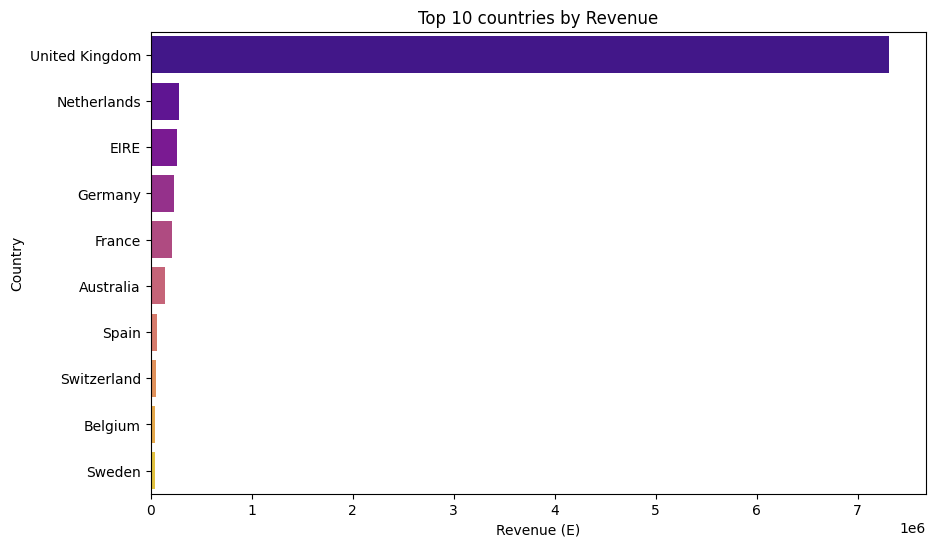

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="plasma")
plt.title("Top 10 countries by Revenue")
plt.xlabel("Revenue (E)")
plt.ylabel("Country")
plt.show()

C:\Users\Saksham Kaushik\AppData\Local\Temp\ipykernel_8620\1051186551.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index,palette="viridis")


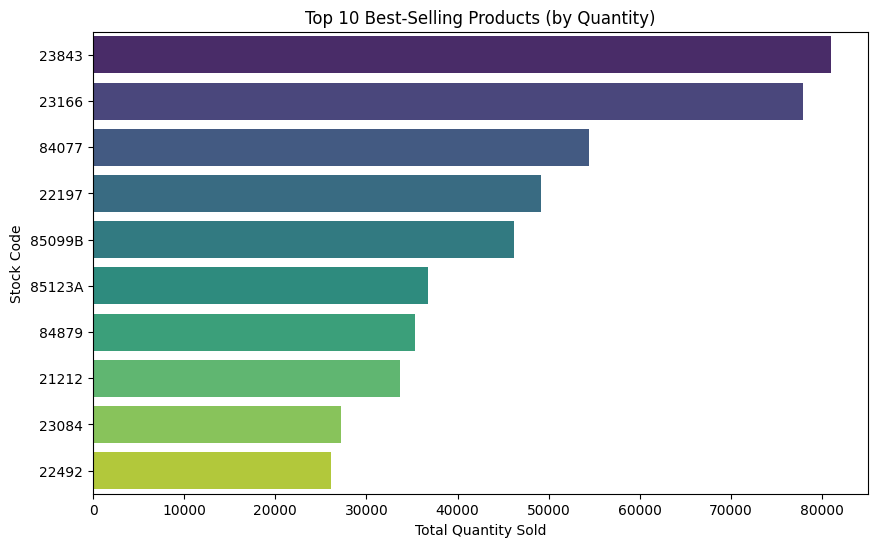

In [25]:
top_products = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index,palette="viridis")
plt.title("Top 10 Best-Selling Products (by Quantity)")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Stock Code")
plt.show()

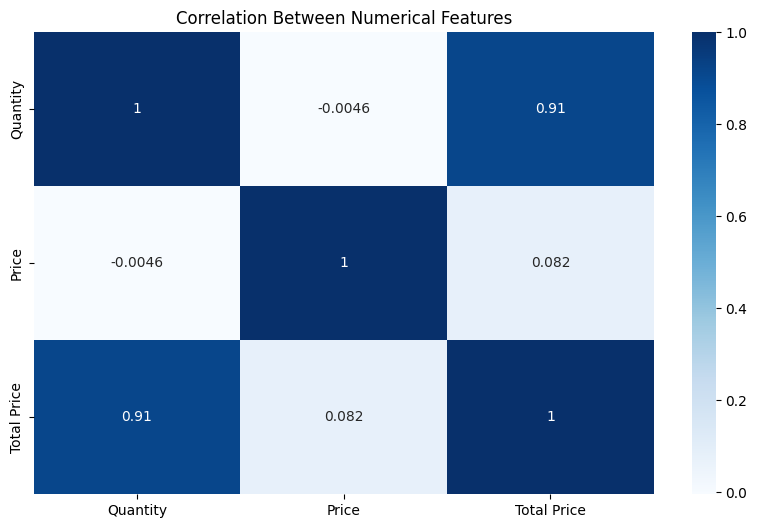

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Quantity', 'Price', 'Total Price']].corr(), annot=True, cmap='Blues')
plt.title("Correlation Between Numerical Features")
plt.show()

C:\Users\Saksham Kaushik\AppData\Local\Temp\ipykernel_8620\1113719043.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df,palette="inferno")


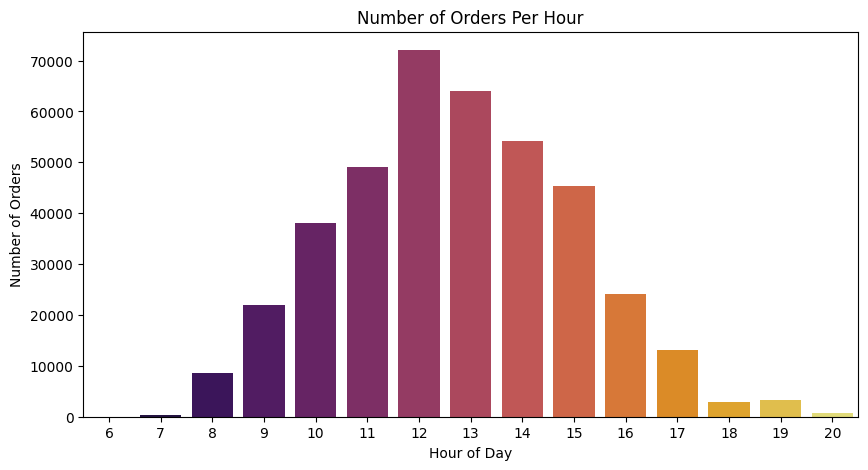

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='Hour', data=df,palette="inferno")
plt.title("Number of Orders Per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.show()

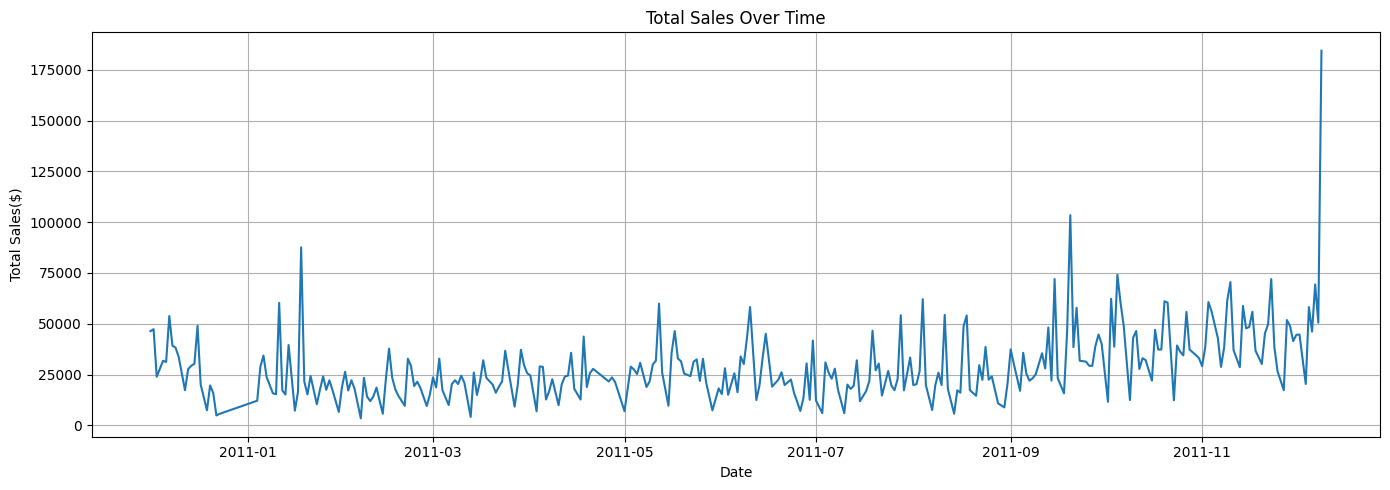

In [28]:
daily_sales = df.groupby('Invoice Day')['Total Price'].sum()
plt.figure(figsize=(14,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales($)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
df["Hour"].unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  7, 18, 19, 20,  6],
      dtype=int32)

In [30]:
hours = [0, 5, 12, 17, 21, 24] 
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']  
df['Session'] = pd.cut(df['Hour'], bins=hours, labels=labels, right=False, include_lowest=True,ordered=False)

In [31]:
df['Session'].unique()

['Morning', 'Afternoon', 'Evening']
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397885 entries, 0 to 541909
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      397885 non-null  object        
 1   StockCode    397885 non-null  object        
 2   Quantity     397885 non-null  int64         
 3   InvoiceDate  397885 non-null  datetime64[ns]
 4   Price        397885 non-null  float64       
 5   Customer ID  397885 non-null  float64       
 6   Country      397885 non-null  object        
 7   Total Price  397885 non-null  float64       
 8   Invoice Day  397885 non-null  object        
 9   Hour         397885 non-null  int32         
 10  Session      397885 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(3), int32(1), int64(1), object(4)
memory usage: 32.3+ MB


In [33]:
import datetime

# Define a reference date (1 day after the last purchase in the dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'Total Price': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [34]:
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
...,...,...,...,...
4333,18280.0,278,1,180.60
4334,18281.0,181,1,80.82
4335,18282.0,8,2,178.05
4336,18283.0,4,16,2094.88


## Without Scaling

In [35]:
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Linear Regression MSE :", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R² Score:", r2_score(y_test, y_pred_lr))


Linear Regression MSE : 67236130.85554697
Linear Regression R² Score: 0.3436716887944494


In [37]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
print("Ridge Regression MSE :", mean_squared_error(y_test, y_pred_ridge))
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_ridge))


Ridge Regression MSE : 67236181.02157897
Ridge Regression R² Score: 0.34367119909662425


In [38]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

print("Random Forest Regressor MSE:", mean_squared_error(y_test, y_pred))
print("Random Forest Regressor R² Score:", r2_score(y_test, y_pred))

Random Forest Regressor MSE: 106149024.14368322
Random Forest Regressor R² Score: -0.03617815103043176


In [39]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R² Score:", r2_score(y_test, y_pred_xgb))


XGBoost MSE: 87662551.78064828
XGBoost R² Score: 0.14427832425733123


## With Scaling

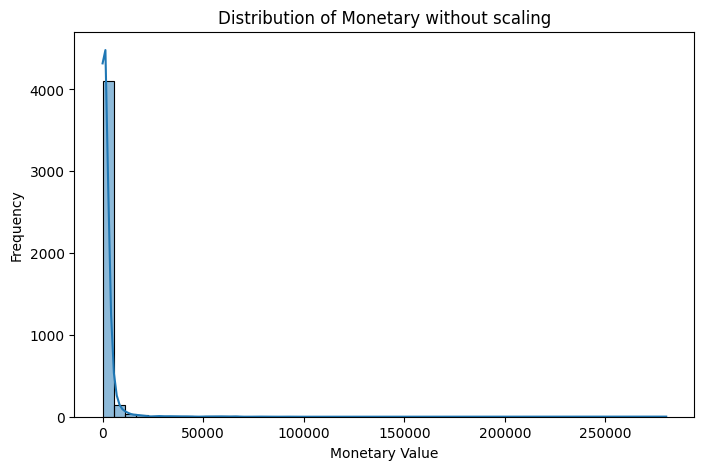

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(rfm['Monetary'], bins=50, kde=True)
plt.title("Distribution of Monetary without scaling")
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.show()

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency']])
features = pd.DataFrame(X_scaled, columns=['Recency', 'Frequency'])
# Apply log1p (log(1 + x)) to reduce skew
target = np.log1p(rfm['Monetary'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

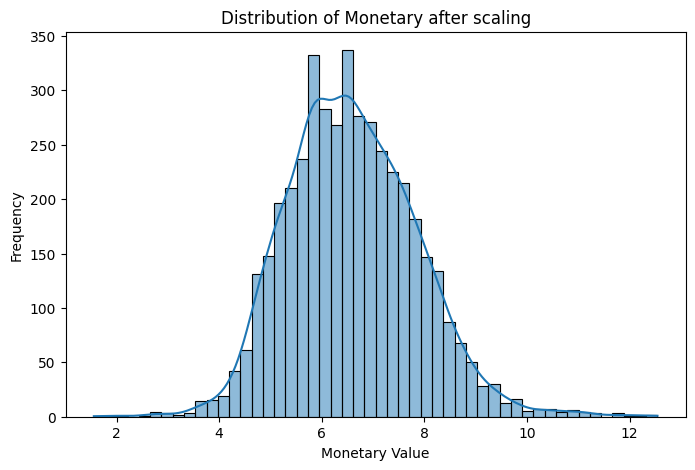

In [43]:
plt.figure(figsize=(8, 5))
sns.histplot(target, bins=50, kde=True)
plt.title("Distribution of Monetary after scaling")
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.show()

In [44]:
# list to store MSE and R2 score
results= []

In [45]:
lr.fit(X_train, y_train)
y_pred_log_lr = lr.predict(X_test)

print("Linear Regression MSE :", mean_squared_error(y_test, y_pred_log_lr))
print("Linear Regression R² Score:", r2_score(y_test, y_pred_log_lr))

results.append(
    {
        "Model":"Linear Regression",
        "MSE" : mean_squared_error(y_test, y_pred_log_lr),
        "R2 score" : r2_score(y_test, y_pred_log_lr) 
    }
)

Linear Regression MSE : 0.8613126807808633
Linear Regression R² Score: 0.4627514292889171


In [46]:
ridge.fit(X_train, y_train)
y_pred_log_ridge = ridge.predict(X_test)

print("Ridge Regression MSE :", mean_squared_error(y_test, y_pred_log_ridge))
print("Ridge Regression R² Score:", r2_score(y_test, y_pred_log_ridge))

results.append(
    {
        "Model":"Ridge Regression",
        "MSE" : mean_squared_error(y_test, y_pred_log_ridge),
        "R2 score" : r2_score(y_test, y_pred_log_ridge) 
    }
)

Ridge Regression MSE : 0.8613208938714834
Ridge Regression R² Score: 0.46274630632800495


In [47]:
rfr.fit(X_train, y_train)
y_pred_log_rfr = rfr.predict(X_test)

print("Random Forest MSE:", mean_squared_error(y_test, y_pred_log_rfr))
print("Random Forest R² Score:", r2_score(y_test, y_pred_log_rfr))

results.append(
    {
        "Model":"Random Forest Regression",
        "MSE" : mean_squared_error(y_test, y_pred_log_rfr),
        "R2 score" : r2_score(y_test, y_pred_log_rfr) 
    }
)

Random Forest MSE: 0.6350120925074081
Random Forest R² Score: 0.6039076787136526


In [48]:
xgb.fit(X_train, y_train)

y_pred_log_xgb = xgb.predict(X_test)
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_log_xgb))
print("XGBoost R² Score:", r2_score(y_test, y_pred_log_xgb))

results.append(
    {
        "Model":" XG Boost Regression",
        "MSE" : mean_squared_error(y_test, y_pred_log_xgb),
        "R2 score" : r2_score(y_test, y_pred_log_xgb) 
    }
)

XGBoost MSE: 0.5080371238197706
XGBoost R² Score: 0.6831090209970057


In [49]:
results_df=pd.DataFrame(results)
print(results_df)

                      Model       MSE  R2 score
0         Linear Regression  0.861313  0.462751
1          Ridge Regression  0.861321  0.462746
2  Random Forest Regression  0.635012  0.603908
3       XG Boost Regression  0.508037  0.683109


In [50]:
rfm_scaled = features
rfm_scaled['Monetary'] = target

In [51]:
rfm_scaled

,Recency,Frequency,Monetary
0,2.334574,-0.425097,11.253955
1,-0.905340,0.354417,8.368925
2,-0.175360,-0.035340,7.494564
3,-0.735345,-0.425097,7.472245
4,2.174578,-0.425097,5.815324
...,...,...,...
4333,1.854587,-0.425097,5.201806
4334,0.884612,-0.425097,4.404522
4335,-0.845342,-0.295178,5.187665
4336,-0.885341,1.523687,7.647729


In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

In [53]:
rfm['Segment']

0       1
1       1
2       1
3       1
4       2
       ..
4333    2
4334    2
4335    0
4336    1
4337    1
Name: Segment, Length: 4338, dtype: int32

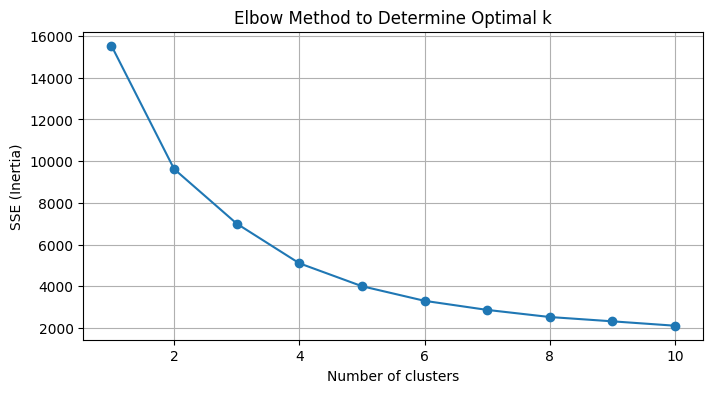

In [54]:
from sklearn.cluster import KMeans

sse = []
K_range= range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()

In [55]:
from kneed import KneeLocator

kneedle = KneeLocator(K_range, sse, curve="convex", direction="decreasing")
print("Best K:", kneedle.elbow)

Best K: 4


In [56]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [57]:
# View average RFM values per cluster
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

,Recency,Frequency,Monetary
Cluster,,,
0,52.6,2.1,540.7
1,35.0,8.1,4188.5
2,253.3,1.4,371.5
3,5.8,77.5,76791.6


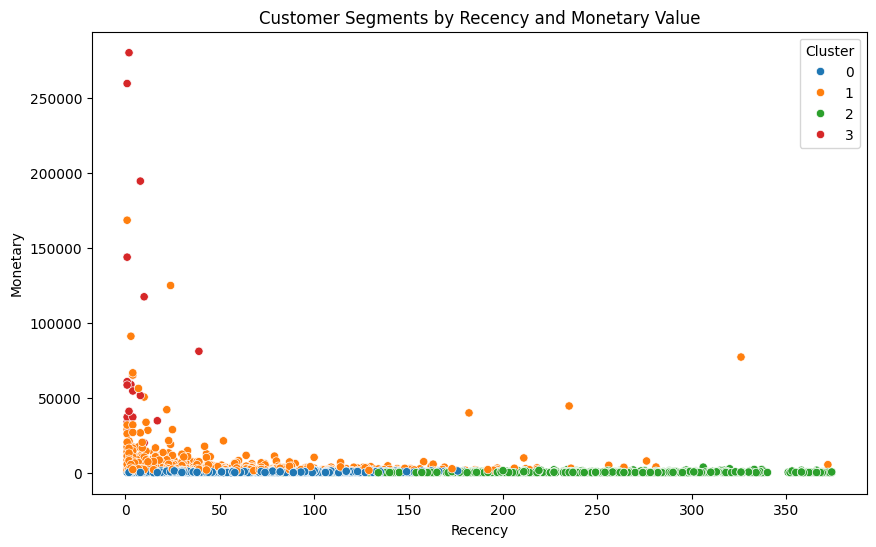

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title('Customer Segments by Recency and Monetary Value')
plt.show()

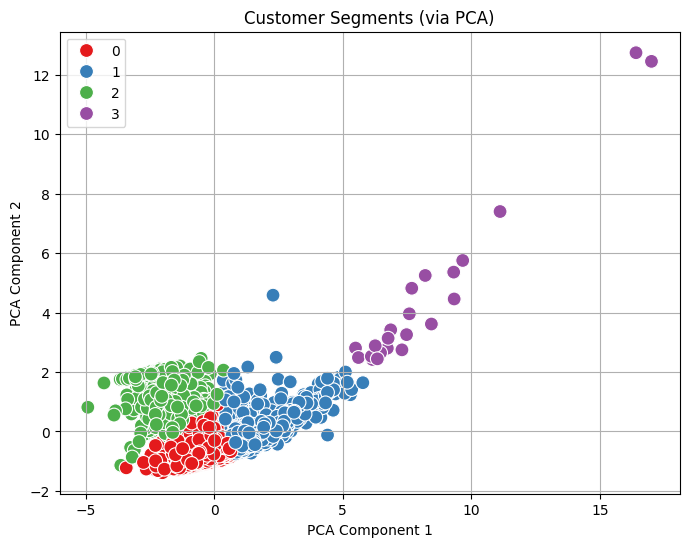

In [59]:
pca = PCA(2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=rfm['Cluster'], palette='Set1', s=100)
plt.title('Customer Segments (via PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
rfm['Label'] = rfm['Cluster'].map({
    0: 'Regulars',
    1: 'Churned',
    2: 'Champions',
    3: 'Loyal Customers'
})

**Champions / VIPs (Cluster 2):**
These are your best customers. They buy very often, spend a lot of money, and have shopped very recently.

**Loyal Customers (Cluster 3):** 
These customers shop regularly, spend a good amount, and have made recent purchases. They are important for steady business.

**Regular Customers (Cluster 0):** 
These customers shop sometimes, not too often or recently, and don’t spend much. They may need more attention to become loyal.

**At Risk / Churned (Cluster 1):**
These customers haven’t shopped in a long time, don’t buy much, and don’t spend much either. They might be leaving your business and     need to be re-engaged.

In [61]:
rfm

,CustomerID,Recency,Frequency,Monetary,Segment,Cluster,Label
0,12346.0,326,1,77183.60,1,1,Churned
1,12347.0,2,7,4310.00,1,1,Churned
2,12348.0,75,4,1797.24,1,1,Churned
3,12349.0,19,1,1757.55,1,1,Churned
4,12350.0,310,1,334.40,2,2,Champions
...,...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,2,2,Champions
4334,18281.0,181,1,80.82,2,2,Champions
4335,18282.0,8,2,178.05,0,0,Regulars
4336,18283.0,4,16,2094.88,1,1,Churned
